## 0. Importing Pytorch and setting up device-agnostic code

In [160]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [161]:
# Setup device-agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data


* Out dataset is subset of the Food101 dataset.
Food101 starts with 101 different classes of food and 1000 images per class(750/250).

* Our dataset starts with 3 classes of food and only 10 % of the images (75/25).

In [162]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path/'pizza_steak_sushi'

# If the image folder doesnt exist, download it and prepare it....
if image_path.is_dir():
  print(f'{image_path} directory already exists....skipping download')
else:
  print(f'{image_path} does not exist, creating one....')
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path/'pizza_steak_sushi.zip','wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downlaoding pizza, steak and sushi data....')
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip','r') as zip_ref:
  print('Unzipping pizza, steak and sushi data....')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists....skipping download
Downlaoding pizza, steak and sushi data....
Unzipping pizza, steak and sushi data....


## 2. Becoming one with the data (data preparation and data exploration)

In [163]:
import os
def walk_through_dir(dir_path):
  ''' Walks through dir_path returining its contents.'''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [164]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [165]:
# Setup train and testing paths

train_dir = image_path/'train'
test_dir = image_path/'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using 'pathlib.Path.parent.stem'
4. Since we're working with images, let's open image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/1503858.jpg
Image class: pizza
Image height: 384
Image widht: 512


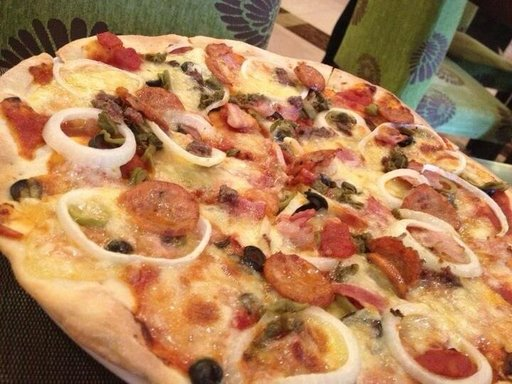

In [166]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# 3. Get image class from path name (the image class is the name of the direcotry where the image is stored)
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image widht: {img.width}')
img

In [167]:
# Try to visualize and image with matplotlib....

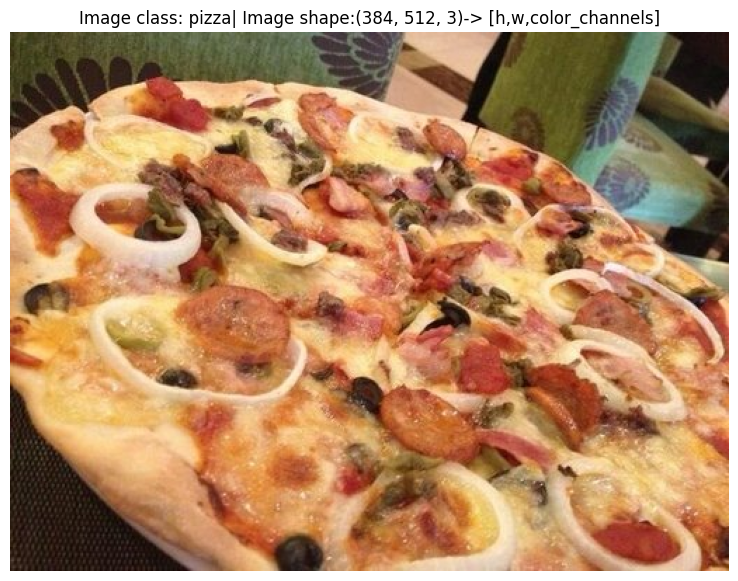

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class}| Image shape:{img_as_array.shape}-> [h,w,color_channels]')
plt.axis(False);

## 3. Transforming data

Before we can use our image data in PyTorch:
1. Turn your target data into tensors(in our case, numerical representation of our images).
2. Turn it into a 'torch.utils.data.Dataset' and subsequently a 'torch.utils.data.Dataloader', we'll call these Dataset and Data Loader.


In [169]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [170]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch tensor
    transforms.ToTensor()
])

In [171]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [172]:
data_transform(img).dtype

torch.float32

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0fb05bb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'


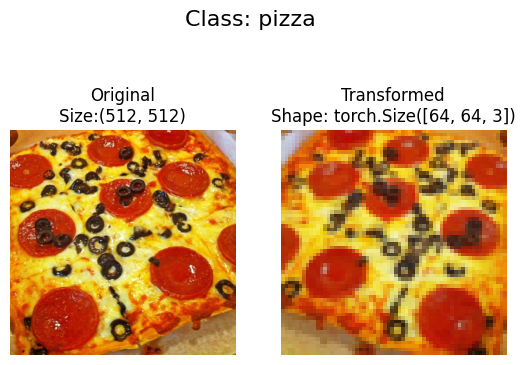

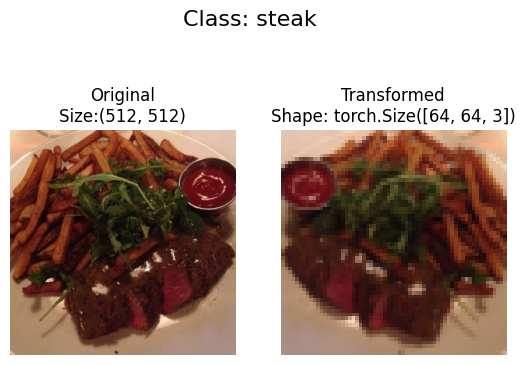

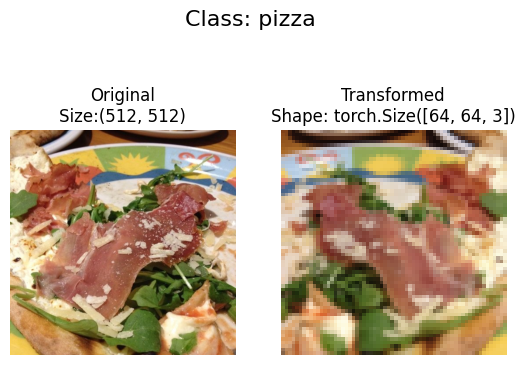

In [173]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  '''
  Select random images from a path of iamges and loads/transform
  them then plots the orginal vs the transformed version
  '''
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize:{f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # Note: we will need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=12)



## 4. Option 1: Loading image using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`.

In [174]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transform for the data
                                  target_transform=None) # Transform for the label/target)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform= data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [175]:
# Get class name as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [176]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [177]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [178]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [179]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Orginal shape: torch.Size([3, 64, 64])
Permute image shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

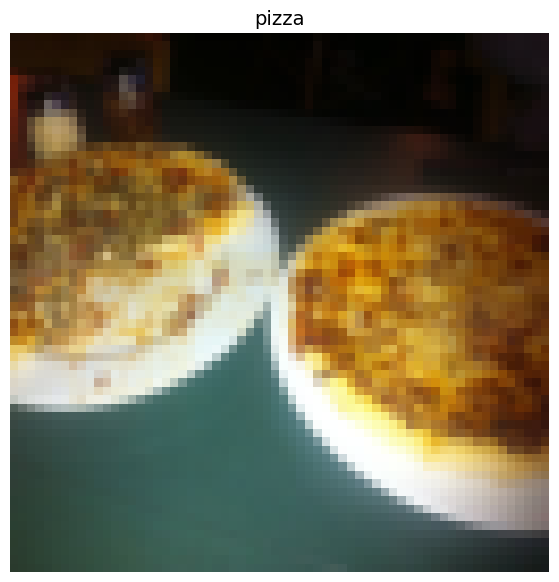

In [180]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)
# Print out different shapes
print(f'Orginal shape: {img.shape}')
print(f'Permute image shape: {img_permute.shape}')

# Plot the image
plt.figure(figsize=(10, 7 ))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded image into `DataLoader's`


A `DataLoader` is going to help us turn our dataset's into iterables and we can customise the batch_size so our model can see batch_size images at a time.

In [181]:
# Just for learning
import os
os.cpu_count()

2

In [182]:
# Turn train and test dataset into DataLoader's

from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size= BATCH_SIZE,
                              num_workers=os.cpu_count(),# more is better
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)


In [183]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f0fa76cd8a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0fa76cc250>)

In [184]:
# As batch size is one rn
len(train_dataloader), len(test_dataloader)

(225, 75)

In [185]:
img, label = next(iter(train_dataloader))

# Batch size will be now be 1, you can change the batch size if you like
print(f'Image shape: {img.shape}-> [Batch_size,color_channel, height,width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64])-> [Batch_size,color_channel, height,width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset.
3. Want to be able to get classes as dictionary from the Dataset.

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` Functions

Cons:
* Even though you could create `Dataset` out of almsot anything,it doesn't mean it will work
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [186]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [187]:
# Instance of torchvision.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

Steps:
1. Get the class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names aren't found.
3. Turn the class names into a dict and a list and return them.

In [188]:
# Setup path for target directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [189]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  '''
  Finds the class folder names in a target directory
  '''
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f'Couldnt find any classes in {directory}....')


  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [190]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

In [191]:
 # 0.Wrte a custom dataset class
 from torch.utils.data import Dataset

 # 1. Subclass torch.utils.data.Dataset
 class ImageFolderCustom(Dataset):
  # 2. Intialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transoforms
    self.transform = transform
    # Create classes and class_to_idx attibutes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int)-> Image.Image:
    '''
    Open an image via a path and return it.
    '''
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self)-> int:
    '''
    Return the total number of samples.
    '''
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int)->Tuple[torch.Tensor, int]:
    '''
    Returns one sample of data, data and label(X,y).
    '''
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return untransformed img and label



In [192]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
                      transforms.Resize(size=(64,64)),
                      transforms.RandomHorizontalFlip(p=0.5),
                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [193]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [194]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f0fa76cfbb0>,
 <__main__.ImageFolderCustom at 0x7f0fa76cdde0>)

In [195]:
len(train_data), len(train_data_custom)

(225, 225)

In [196]:
len(test_data), len(test_data_custom)

(75, 75)

In [197]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [198]:
# Check for equality between original ImageFolder Dataset and custom created above

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.

2. To prevent the display getting out of hand, let's cap the number of images to see at 10.

3. Set the random seed for reproducibility.

4. Get a list of random sample indexes from the target dataset.

5. Setup a matplotlib plot.

6. Loop through the random samples images and plot them with matplotlib.

7. Make sure the dimensions of our images line up with matplotlib (HWC).

In [199]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n:int =10,
                          display_shape: bool=True,
                          seed: int=None):
  # 2. Adjust display if n is too high
  if n>10:
    n = 10
    display_shape = False
    print(f'For display purpose n shouldnt be lager than 10, setting it to 10.')

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # Plot adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
    plt.title(title)





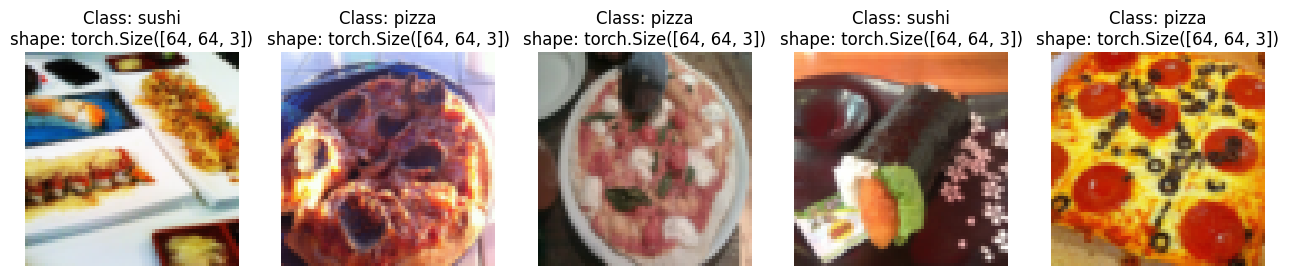

In [200]:
# Display random images from the ImageFolder created Dataset

display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

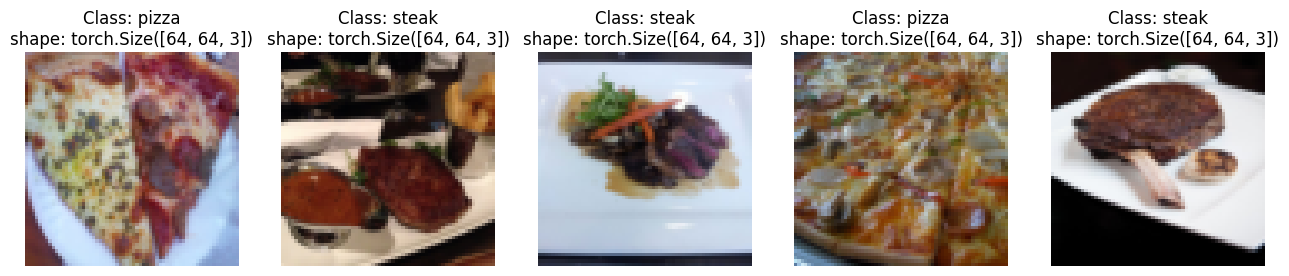

In [201]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into `DataLoader`

In [202]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers= os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers= os.cpu_count(),
                                    shuffle=False)

In [203]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f0fa7517c70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0fa75172b0>)

In [204]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transform (data augmentation)


Data augmentation is the process of artificaially adding diversity to your training data.

In the case of image data, this mean applying various images transformations to the training images.


This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels....


In [205]:
 # Let's try TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # range 1 to 31 with 1 just rotating and 31 is highest intensitiy
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [206]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg')]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0fb05bb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0fb05bb880>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1409, in _shutdown_workers
    if not self._shutdown:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_shutdown'
Exception ignored in: <function _Mul

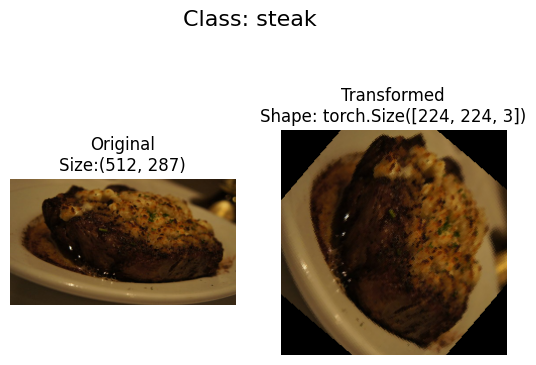

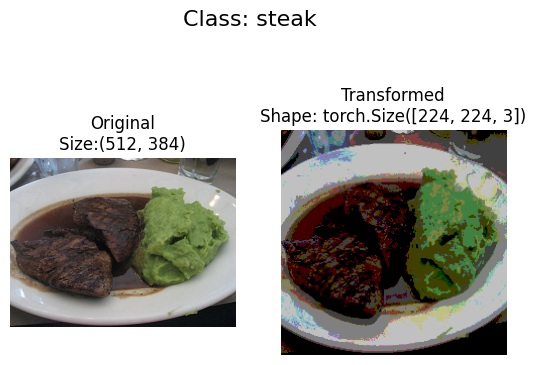

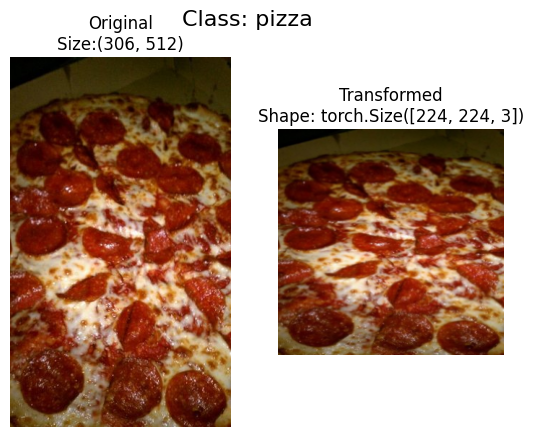

In [207]:
# Plot random transformed images

plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

## 7. Model 0: TinyVgg without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [208]:
# Create a simple transform
simple_transform =  transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [209]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_sampler=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

 ### 7.2 Create TinyVGG model class

In [210]:
class TinyVGG(nn.Module):
  """
  Model acrhitecture copying TinyVGG
  """
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int) ->None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )


  def forward(self,x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [211]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [212]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [213]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get idea of shapes going through the model

In [214]:
# Install torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops function

In [223]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0,0

  for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred,y)
      train_loss+=loss.item()

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
      train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss/len(dataloader)
  train_acc = train_acc/len(dataloader)
  return train_loss, train_acc

In [224]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits,y)
      test_loss+= loss.item()

      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine train_step() and test_step()

In [225]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters ....
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device = device):
  # 2. Create empty results dictionary
  results = {'train_loss':[],
             'train_acc':[],
             'test_loss':[],
             'test_acc':[]}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

  # 4. Print out what's happening
    print(f'Epoch:{epoch}|Train_loss:{train_loss:.4f}|Train_acc:{train_acc:.4f}|Test_loss:{test_loss:.4f}|Test_acc:{test_acc:.4f}')

  # 5. Update results dictionary
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

 # 6.  Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaulate model_0

In [226]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: 'int' object is not iterable